# Baseline Text Classification


ACEInhibitors dataset from: https://www.dropbox.com/sh/ud5sf1fy6m7o219/AAD9pkY5gYe_XYV2oHDw68uva?dl=0

### Libraries and methods

In [1]:
#libraries
import pandas as pd
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import regexp_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
#preprocessing methods 

def clean_text(df, col):
    """A function for keeping only alpha-numeric characters and replacing all 
    white space with a single space.
    """
    return df[col].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', str(x).lower()))\
                  .apply(lambda x: re.sub('\s+', ' ', x).strip())

def flatten_words(list1d, get_unique=False):
    qa = [s.split() for s in list1d]
    if get_unique:
        return sorted(list(set([w for sent in qa for w in sent])))
    else:
        return [w for sent in qa for w in sent]

def features(df, text, text_clean):
    df = df.copy()
    df['n_questionmarks'] = count_pattern(df, text, '\?')
    df['n_periods'] = count_pattern(df, text, '\.')
    df['n_apostrophes'] = count_pattern(df, text, '\'')
    df['first_word'] = df[text_clean].apply(lambda x: split_on_word(x)[0])
    question_words = ['what', 'how', 'why', 'is']
    for w in question_words:
        col_wc = 'n_' + w
        col_fw = 'fw_' + w
        df[col_wc] = count_pattern(df, text_clean, w)
        df[col_fw] = (df.first_word == w) * 1
        
    del df['first_word']
    
    df['n_words'] = df[text].apply(lambda x: len(split_on_word(x)))
    return df

def count_pattern(df, col, pattern):
    """Count the occurrences of `pattern`
    in df[col].
    """
    df = df.copy()
    return df[col].str.count(pattern)

def split_on_word(text):
    """Use regular expression tokenizer.
    Keep apostrophes.
    Returns a list of lists, one list for each sentence:
        [[word, word], [word, word, ..., word], ...].
    """
    if type(text) is list:
        return [regexp_tokenize(sentence, pattern="\w+(?:[-']\w+)*") for sentence in text]
    else:
        return regexp_tokenize(text, pattern="\w+(?:[-']\w+)*")

### Import of data

In [3]:
#import of data
data = pd.read_csv('/content/ACEInhibitors.tsv', sep='\t')
print(data.shape)
display(data.head(3))

(2544, 53)


,PMID,OWN,STAT,DCOM,LR,IS,VI,IP,DP,Title,PG,Abstract,FAU,AU,AD,LA,PT,PL,TA,JT,JID,RN,SB,MH,EDAT,MHDA,CRDT,PHST,AID,PST,SO,GR,CIN,EIN,RF,CI,PMC,CON,OTO,OT,IR,FIR,IRAD,CRI,LID,CN,TT,OID,SPIN,DEP,ORI,RIN,Label
0,10024335,NLM,MEDLINE,19990309,20190722,0194-911X (Print) 0194-911X (Linking),33,2,1999 Feb,Distinct and combined vascular effects of ACE ...,719-25,Hypercholesterolemia and hypertension are freq...,"['Nazzaro, P', 'Manzari, M', 'Merlo, M', 'Trig...","['Nazzaro P', 'Manzari M', 'Merlo M', 'Triggia...",['Department of Clinical Methodology and Medic...,['eng'],"['Clinical Trial', 'Controlled Clinical Trial'...",United States,Hypertension,"Hypertension (Dallas, Tex. : 1979)",7906255,['0 (Angiotensin-Converting Enzyme Inhibitors)...,IM,"['Adult', 'Angiotensin-Converting Enzyme Inhib...",1999/02/19 00:00,1999/02/19 00:01,['1999/02/19 00:00'],"['1999/02/19 00:00 [pubmed]', '1999/02/19 00:0...",['10.1161/01.hyp.33.2.719 [doi]'],ppublish,Hypertension. 1999 Feb;33(2):719-25. doi: 10.1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,10027665,NLM,MEDLINE,19990506,20190813,0031-6970 (Print) 0031-6970 (Linking),54,11,1999 Jan,Computerized surveillance of adverse drug reac...,887-92,OBJECTIVE: To implement and measure the effect...,"['Levy, M', 'Azaz-Livshits, T', 'Sadan, B', 'S...","['Levy M', 'Azaz-Livshits T', 'Sadan B', 'Shal...","['Department of Medicine, Hadassah University ...",['eng'],"['Journal Article', ""Research Support, Non-U.S...",Germany,Eur J Clin Pharmacol,European journal of clinical pharmacology,1256165,NaN,IM,['Adverse Drug Reaction Reporting Systems/econ...,1999/02/23 00:00,1999/02/23 00:01,['1999/02/23 00:00'],"['1999/02/23 00:00 [pubmed]', '1999/02/23 00:0...",['10.1007/s002280050571 [doi]'],ppublish,Eur J Clin Pharmacol. 1999 Jan;54(11):887-92. ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,10027935,NLM,MEDLINE,19990416,20161124,0085-2538 (Print) 0085-2538 (Linking),55,3,1999 Mar,Glomerular size-selective dysfunction in NIDDM...,984-94,BACKGROUND: In patients with insulin-dependent...,"['Ruggenenti, P', 'Mosconi, L', 'Sangalli, F',...","['Ruggenenti P', 'Mosconi L', 'Sangalli F', 'C...","['Department of Kidney Research, Mario Negri I...",['eng'],"['Clinical Trial', 'Journal Article', 'Randomi...",United States,Kidney Int,Kidney international,0323470,['0 (Angiotensin-Converting Enzyme Inhibitors)...,IM,"['Adult', 'Aged', 'Angiotensin-Converting Enzy...",1999/02/23 00:00,1999/02/23 00:01,['1999/02/23 00:00'],"['1999/02/23 00:00 [pubmed]', '1999/02/23 00:0...","['10.1046/j.1523-1755.1999.055003984.x [doi]',...",ppublish,Kidney Int. 1999 Mar;55(3):984-94. doi: 10.104...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
#maintainig only interesting columns
df = data[["Abstract", "Label"]]
display(df.head())

,Abstract,Label
0,Hypercholesterolemia and hypertension are freq...,0
1,OBJECTIVE: To implement and measure the effect...,0
2,BACKGROUND: In patients with insulin-dependent...,0
3,Aortic root flow and pressure estimates were o...,0
4,BACKGROUND: Population-based studies have foun...,0


In [5]:
#checking missing values
print(df.shape)
display(df.isnull().sum(axis=0))
df = df.dropna()
print(df.shape)

(2544, 2)


Abstract    309
Label         0
dtype: int64

(2235, 2)


In [6]:
#label distribution
df["Label"].value_counts()

0    2194
1      41
Name: Label, dtype: int64

### Data preprocessing

In [7]:
#text preprocessing
df['abstract_clean'] = clean_text(df, 'Abstract')

In [8]:
#splitting train and test set
train, test, y_train, y_test = train_test_split(
    df.loc[:, df.columns!="Label"], df["Label"],   
    test_size=0.2, random_state=42, shuffle=True)

#resetting indexes for concat()
train = train.reset_index(drop=True) 
test = test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [9]:
print("Training set:", train.shape)
print("Test set:", test.shape)

Training set: (1788, 2)
Test set: (447, 2)


In [10]:
#tf-idf
all_text = train["abstract_clean"].values.tolist() + test["abstract_clean"].values.tolist()
vocab = flatten_words(all_text, get_unique=True)
tfidf = TfidfVectorizer(stop_words='english', vocabulary=vocab)
training_matrix = tfidf.fit_transform(train["abstract_clean"])
test_matrix = tfidf.fit_transform(test["abstract_clean"])

In [11]:
print("Training matrix:", training_matrix.shape)
print("Test matrix:", test_matrix.shape)

Training matrix: (1788, 12633)
Test matrix: (447, 12633)


In [12]:
#other features for train set
train = features(train, "Abstract", "abstract_clean")
print(train.shape)
train = pd.concat([train, pd.DataFrame(training_matrix.todense())], axis=1)
print(train.shape)
display(train.head(3))

(1788, 14)
(1788, 12647)


,Abstract,abstract_clean,n_questionmarks,n_periods,n_apostrophes,n_what,fw_what,n_how,fw_how,n_why,fw_why,n_is,fw_is,n_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,12593,12594,12595,12596,12597,12598,12599,12600,12601,12602,12603,12604,12605,12606,12607,12608,12609,12610,12611,12612,12613,12614,12615,12616,12617,12618,12619,12620,12621,12622,12623,12624,12625,12626,12627,12628,12629,12630,12631,12632
0,The biological effects of dose-dependent inhib...,the biological effects of dose dependent inhib...,0,20,0,0,0,0,0,0,0,3,0,219,0.0,0.0,0.223297,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BACKGROUND: Angiotensin-converting enzyme inhi...,background angiotensin converting enzyme inhib...,0,28,0,0,0,0,0,0,0,1,0,292,0.0,0.0,0.000000,0.0,0.0,0.080835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,OBJECTIVE: To assess the efficacy and safety o...,objective to assess the efficacy and safety of...,0,21,0,0,0,0,0,0,0,4,0,347,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031029,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#other feature for test set
test = features(test, "Abstract", "abstract_clean")
test = pd.concat([test, pd.DataFrame(test_matrix.todense())], axis=1)
print(test.shape)
display(test.head(3))

(447, 12647)


,Abstract,abstract_clean,n_questionmarks,n_periods,n_apostrophes,n_what,fw_what,n_how,fw_how,n_why,fw_why,n_is,fw_is,n_words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,12593,12594,12595,12596,12597,12598,12599,12600,12601,12602,12603,12604,12605,12606,12607,12608,12609,12610,12611,12612,12613,12614,12615,12616,12617,12618,12619,12620,12621,12622,12623,12624,12625,12626,12627,12628,12629,12630,12631,12632
0,ACE inhibitors have achieved widespread usage ...,ace inhibitors have achieved widespread usage ...,0,7,0,0,0,0,0,0,0,8,0,197,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OBJECTIVE: Autonomic nervous system function i...,objective autonomic nervous system function in...,0,22,0,0,0,0,0,0,0,12,0,354,0.0,0.19036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025457,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084229,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"In most cases, the antihypertensive therapy fo...",in most cases the antihypertensive therapy for...,0,9,0,0,0,0,0,0,0,3,0,218,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.047659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#splitting train and validation set
train, val, y_train, y_val = train_test_split(
    train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [15]:
#scaling data
scaler = StandardScaler()
features = train.columns[3:] #all columns except Abstract, abstract_clean and target
X = scaler.fit_transform(train[features].values)
y = y_train.values
features_val = scaler.transform(val[features].values)

### Training with SVM

In [16]:
#svm training
svm = LinearSVC(class_weight="balanced", random_state=1)
svm = svm.fit(X, y)

In [17]:
val_predicted = svm.predict(features_val)

#### SVM results

In [18]:
#accuracy
accuracy_score(y_val, val_predicted)

0.9497206703910615

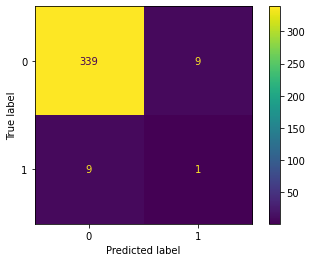

In [19]:
#confusion matrix
cm = confusion_matrix(y_val, val_predicted, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [20]:
#evaluation metrics
report = classification_report(y_val, val_predicted, output_dict=True)
pd.DataFrame(report).transpose().round(decimals=3)

,precision,recall,f1-score,support
0,0.974,0.974,0.974,348.00
1,0.100,0.100,0.100,10.00
accuracy,0.950,0.950,0.950,0.95
macro avg,0.537,0.537,0.537,358.00
weighted avg,0.950,0.950,0.950,358.00


### Training with Decision Tree

In [21]:
#DT training
dt = tree.DecisionTreeClassifier(random_state=1, class_weight="balanced")
dt = dt.fit(X, y)

In [22]:
#prediction on validation set
val_predicted = dt.predict(features_val)

#### Decision Tree results

In [23]:
#accuracy
accuracy_score(y_val, val_predicted)

0.9636871508379888

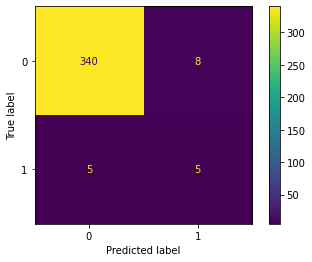

In [24]:
#confusion matrix
cm = confusion_matrix(y_val, val_predicted, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [25]:
#evaluation metrics
report = classification_report(y_val, val_predicted, zero_division=0, output_dict=True)
pd.DataFrame(report).transpose().round(decimals=3)

,precision,recall,f1-score,support
0,0.986,0.977,0.981,348.000
1,0.385,0.500,0.435,10.000
accuracy,0.964,0.964,0.964,0.964
macro avg,0.685,0.739,0.708,358.000
weighted avg,0.969,0.964,0.966,358.000


### Training with Random Forest

In [26]:
#Random forest training
forest = RandomForestClassifier(random_state=1, class_weight="balanced")
forest = forest.fit(X, y)

In [27]:
#prediction on validation set
val_predicted = forest.predict(features_val)

#### Random forest results

In [28]:
#accuracy
accuracy_score(y_val, val_predicted)

0.9720670391061452

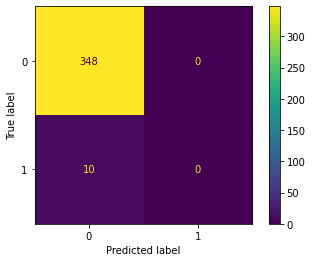

In [29]:
#confusion matrix
cm = confusion_matrix(y_val, val_predicted, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [30]:
#evaluation metrics
report = classification_report(y_val, val_predicted, zero_division=0, output_dict=True)
pd.DataFrame(report).transpose().round(decimals=3)

,precision,recall,f1-score,support
0,0.972,1.000,0.986,348.000
1,0.000,0.000,0.000,10.000
accuracy,0.972,0.972,0.972,0.972
macro avg,0.486,0.500,0.493,358.000
weighted avg,0.945,0.972,0.958,358.000
